In [1]:
# !pip install xarray eotransform_pandas dask geopathfinder rioxarray matplotlib

In [2]:
import numpy as np
import glob
import os
from datetime import datetime
from pprint import pprint
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
# DATA_PATH = './data/S1_CSAR_IWGRDH_fields/S1_CSAR_IWGRDH/SIG0/V0M2R4/EQUI7_AF020M/E069N087T3'
# DATA_PATH = './data/S1_CSAR_IWGRDH/SIG0/V0M2R4/EQUI7_AF020M/E069N084T3'
# DATA_PATH = './data/S1_CSAR_IWGRDH/SIG0/V0M2R4/EQUI7_EU020M/E045N012T3'
DATA_PATH = '/data/soil_roughness/SIG0-ROI-4580030-1334708-4684421-1362975/SIG0-ROI-4580030-1334708-4684421-1362975/V1M0R1/EQUI7_EU020M/E045N012T3'

In [5]:
# !rm {DATA_PATH}/*.aux.xml

In [6]:
##### yeoda_naming_convention
# fields_def = OrderedDict([
#     ('var_name', {'len': 0}),
#     ('datetime_1', {'len': 0}),
#     ('datetime_2', {'len': 0}),
#     ('band', {'len': 0}),
#     ('extra_field', {'len': 0}),
#     ('tile_name', {'len': 0}),
#     ('grid_name', {'len': 0}),
#     ('data_version', {'len': 0}),
#     ('sensor_field', {'len': 0}),
#     ('creator', {'len': 0})
# ])

In [7]:
import xarray as xr
from pathlib import Path
from eotransform_pandas.filesystem.gather import gather_files

from eotransform_pandas.filesystem.naming.geopathfinder_conventions import yeoda_naming_convention

# gather all the tiffs in a pandas DataFrame (the file names follow a
# special yeoda naming convention which is parsed and populates the df
# with meta data such as sensing time

tiffs_df = gather_files(Path(DATA_PATH), yeoda_naming_convention, index="datetime_1")
# index="datetime_1" means
# tiffs are sorted by sensing time which is what you generally want when
# looking at time series data

# you can do some other filtering sorting or processing of the data
# frame here of course to only select the files you are interested in
# using standard pandas procedures

# then load the stack of tiffs into a data cube

# the 'chunk={}' means that files are lazy loaded and xarray will use
# dask for processing which can speed up things on machines with multiple
# cores

# 'concat_dim' signifies what the stacking order of the tiffs means - as
# mentioned before you usually want to stack by sensing time, hence 'time'

stack_ds = xr.open_mfdataset(
    tiffs_df['filepath'],
    engine='rasterio',
    chunks={},
    combine='nested',
    concat_dim='time'
)

# 'xr.open_mfdataset' returns a Dataset object containing one DataArray
# called 'band_data' this is just how GeoTiffs do

stack_da = stack_ds['band_data']

# now you can select your region of interest - I'd recommend keeping it
# small for now so you don't have to process for ages

# look into the xarray docs for how to select an manipulate the data
# cube https://docs.xarray.dev/en/stable/user-guide/indexing.html

# this function transforms the data in decibel (which is how the data is
# stored within the GeoTiffs) to linear space

# def db2lin(x):
#     return 10.0 ** (x / 10.0)

# and the other way around from linear scale to logarithmic

# def lin2db(x):
#     return 10 * np.log10(x)

In [8]:
stack_ds

<xarray.Dataset>
Dimensions:      (band: 1, x: 5221, y: 1414, time: 1535)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.58e+06 4.58e+06 4.58e+06 ... 4.684e+06 4.684e+06
  * y            (y) float64 1.363e+06 1.363e+06 ... 1.335e+06 1.335e+06
    spatial_ref  int64 0
Dimensions without coordinates: time
Data variables:
    band_data    (time, band, y, x) float32 dask.array<chunksize=(1, 1, 1, 5221), meta=np.ndarray>

In [9]:
stack_da

<xarray.DataArray 'band_data' (time: 1535, band: 1, y: 1414, x: 5221)>
dask.array<concatenate, shape=(1535, 1, 1414, 5221), dtype=float32, chunksize=(1, 1, 1, 5221), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.58e+06 4.58e+06 4.58e+06 ... 4.684e+06 4.684e+06
  * y            (y) float64 1.363e+06 1.363e+06 ... 1.335e+06 1.335e+06
    spatial_ref  int64 0
Dimensions without coordinates: time
Attributes: (12/40)
    abs_orbit_number:       3665
    AREA_OR_POINT:          Area
    band:                   VV
    border_noise_removed:   True
    creation_date:          2021-08-07 17:57:07
    creator:                TUWIEN
    ...                     ...
    worker_git_tag:         from v1.0.0 to v1.1.0
    worker_name:            s1-sigma
    wrapper_git_commit:     none
    wrapper_git_tag:        v1.0.0
    wrapper_name:           gfm-sigma-offline
    long_name:              band_data

In [10]:
stack_ds.keys()

KeysView(<xarray.Dataset>
Dimensions:      (band: 1, x: 5221, y: 1414, time: 1535)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.58e+06 4.58e+06 4.58e+06 ... 4.684e+06 4.684e+06
  * y            (y) float64 1.363e+06 1.363e+06 ... 1.335e+06 1.335e+06
    spatial_ref  int64 0
Dimensions without coordinates: time
Data variables:
    band_data    (time, band, y, x) float32 dask.array<chunksize=(1, 1, 1, 5221), meta=np.ndarray>)

In [11]:
stack_ds.x

<xarray.DataArray 'x' (x: 5221)>
array([4580030., 4580050., 4580070., ..., 4684390., 4684410., 4684430.])
Coordinates:
  * x            (x) float64 4.58e+06 4.58e+06 4.58e+06 ... 4.684e+06 4.684e+06
    spatial_ref  int64 0

In [12]:
stack_ds.y

<xarray.DataArray 'y' (y: 1414)>
array([1362970., 1362950., 1362930., ..., 1334750., 1334730., 1334710.])
Coordinates:
  * y            (y) float64 1.363e+06 1.363e+06 ... 1.335e+06 1.335e+06
    spatial_ref  int64 0

In [13]:
stack_da.shape

(1535, 1, 1414, 5221)

In [14]:
tiffs_df.index

DatetimeIndex(['2017-01-03 05:35:23', '2017-01-04 05:26:30',
               '2017-01-04 17:22:43', '2017-01-05 17:13:42',
               '2017-01-09 05:34:34', '2017-01-10 05:27:05',
               '2017-01-10 17:21:57', '2017-01-11 17:14:26',
               '2017-01-15 05:35:23', '2017-01-16 05:26:26',
               ...
               '2021-12-15 05:27:49', '2021-12-15 17:22:26',
               '2021-12-16 17:15:09', '2021-12-20 05:35:36',
               '2021-12-20 05:36:01', '2021-12-21 05:26:58',
               '2021-12-21 17:23:15', '2021-12-22 17:14:14',
               '2021-12-27 05:27:48', '2021-12-28 17:15:09'],
              dtype='datetime64[ns]', name='datetime_1', length=1535, freq=None)

In [15]:
stack_da = stack_da.assign_coords(time=("time", tiffs_df.index))

In [16]:
# 4010434.886,3663682.403

> 1. Am I correctly understanding that the first dimension refers to "time" in days and the third and fourth refer to position (incoordinate)?
Yes.

> 2. Is the time dimension starting from 'sensing_date'?
The time dimension has the same order you provided the list of files, so usually yes. However, depending on your file system and the way you feed the tif files (i.e. if you use the wildcard) to the xarray function, you might need to sort by time to make sure the data is ordered correctly.  You'd need to check - the sensing date is also part of the file name. Have a look at the xarray documentation  (i.e. https://docs.xarray.dev/en/stable/user-guide/indexing.html) on how files are loaded and how to sort dimensions

> 3. Can we know from the attributes where (e.g., latitude/longitude) are the location of the positions? Is there anything specified in the data attributes?
If you load via xarray the 'x' and 'y' dimensions should already contain the correct coordinates, check again the xarray documentation.  If not, try specifying `decode_coords='all'` as well when loading the tiffs. GeoTiffs, are already geo-referenced, however, in our case not with lon/lat but using the Equi7 Grid (https://github.com/TUW-GEO/Equi7Grid) instead. The projection is stored within the GeoTiff metadata defining the coordinate system.  Have a look at the GeoTiff specifications or the much more readable rioxarray documentation (https://corteva.github.io/rioxarray/stable/).

> 4. How large is the area of a unit square (1,1)?
20m. You can find information like that also in the metadata of the GeoTiff. Btw. my recommended tool to look at GeoTiffs would be QGIS. In QGIS you can also load Google Maps Satellite pictures and OpenStreet map data to get a sense of where the data is located - QGIS will take care to get everything in the same projection. Just look at the QGIS documentation on how to add Google Maps or XYZ layers in general.

> 5. What is the second coordinate referring to?
This is the band, in our case we only have one for now, but potentially you could also load RGB or hyper-spectral images. In the future we might have 2 if we add the cross-polarized radar image as well (VH) currently we only work with co-polarized images (VV), so for now don't concern yourself with it.

In [17]:
# stack_ds

In [18]:
stack_da.sel(time=slice("2021-11-30", "2021-12-31"))

<xarray.DataArray 'band_data' (time: 20, band: 1, y: 1414, x: 5221)>
dask.array<getitem, shape=(20, 1, 1414, 5221), dtype=float32, chunksize=(1, 1, 1, 5221), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.58e+06 4.58e+06 4.58e+06 ... 4.684e+06 4.684e+06
  * y            (y) float64 1.363e+06 1.363e+06 ... 1.335e+06 1.335e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2021-12-02T05:35:04 ... 2021-12-28T17:...
Attributes: (12/40)
    abs_orbit_number:       3665
    AREA_OR_POINT:          Area
    band:                   VV
    border_noise_removed:   True
    creation_date:          2021-08-07 17:57:07
    creator:                TUWIEN
    ...                     ...
    worker_git_tag:         from v1.0.0 to v1.1.0
    worker_name:            s1-sigma
    wrapper_git_commit:     none
    wrapper_git_tag:        v1.0.0
    wrapper_name:           gfm-sigma-offline
    long_name:              band_data

In [19]:
%%time
# 4621389.5,1348422.3
# 4621624.4,1348401.1
# 4621341.8,1347966.7
# 4621511.4,1347952.5
tmp = stack_da.sel(
    x = slice(4621389.5, 4621511.4),
    y = slice(1348422.3, 1347952.5),
).resample(time='W').mean().mean(dim=['x', 'y'], skipna=True)[:, 0].to_pandas()
    # time=slice("2021-11-30", "2021-12-31")
# )[:, 0].resample(time='W').mean().plot.line()
# stack_da[:, 0, 8, 8].resample(time='W').mean().plot.line()

CPU times: user 45.1 s, sys: 17.2 s, total: 1min 2s
Wall time: 1min 7s


In [20]:
tmp

time
2017-01-08   -11.288406
2017-01-15   -15.190994
2017-01-22   -13.955590
2017-01-29   -11.371428
2017-02-05   -10.156936
                ...    
2021-12-05   -10.914907
2021-12-12   -11.578468
2021-12-19   -10.136232
2021-12-26   -10.688199
2022-01-02    -9.962112
Freq: W-SUN, Length: 261, dtype: float32

In [21]:
time_index = stack_da.sel(
    x = slice(4621389.5, 4621511.4),
    y = slice(1348422.3, 1347952.5),
).resample(time='W').mean().mean(dim=['x', 'y'], skipna=True).time.values

In [22]:
len(time_index)

261

In [23]:
tmp.index = time_index

In [24]:
groups = tmp.groupby(tmp.index.year)

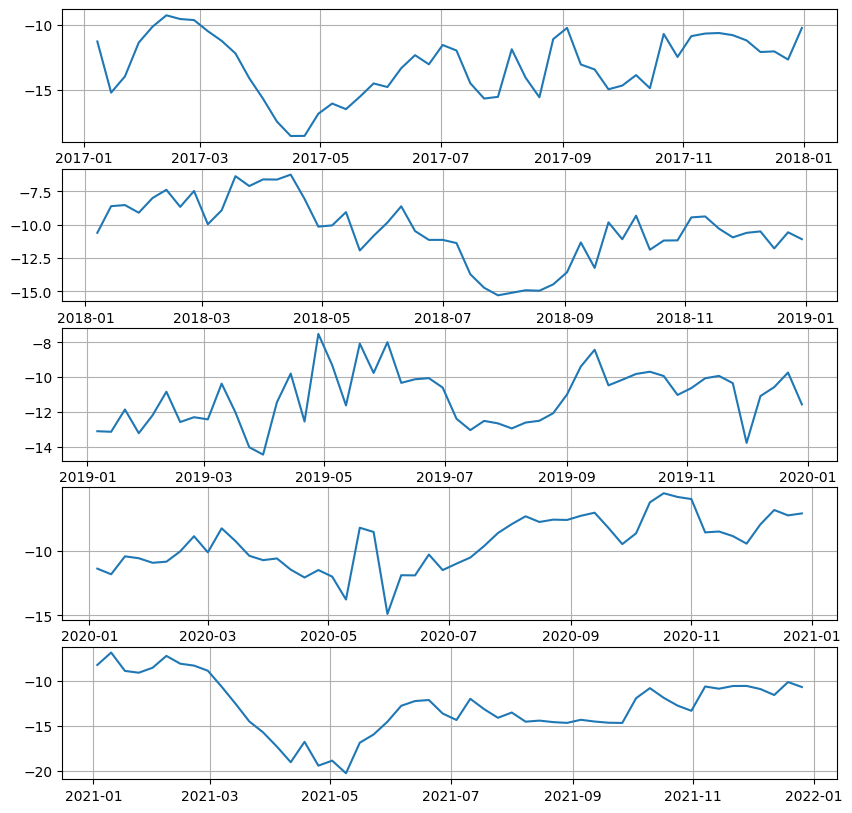

In [25]:
plt.rcParams['axes.grid'] = True
fig, axes = plt.subplots(5, 1)
fig.set_figheight(10)
fig.set_figwidth(10)
axes[0].plot(groups.get_group(2017))
axes[1].plot(groups.get_group(2018))
axes[2].plot(groups.get_group(2019))
axes[3].plot(groups.get_group(2020))
axes[4].plot(groups.get_group(2021))
# axes[5].plot(groups.get_group(2022))


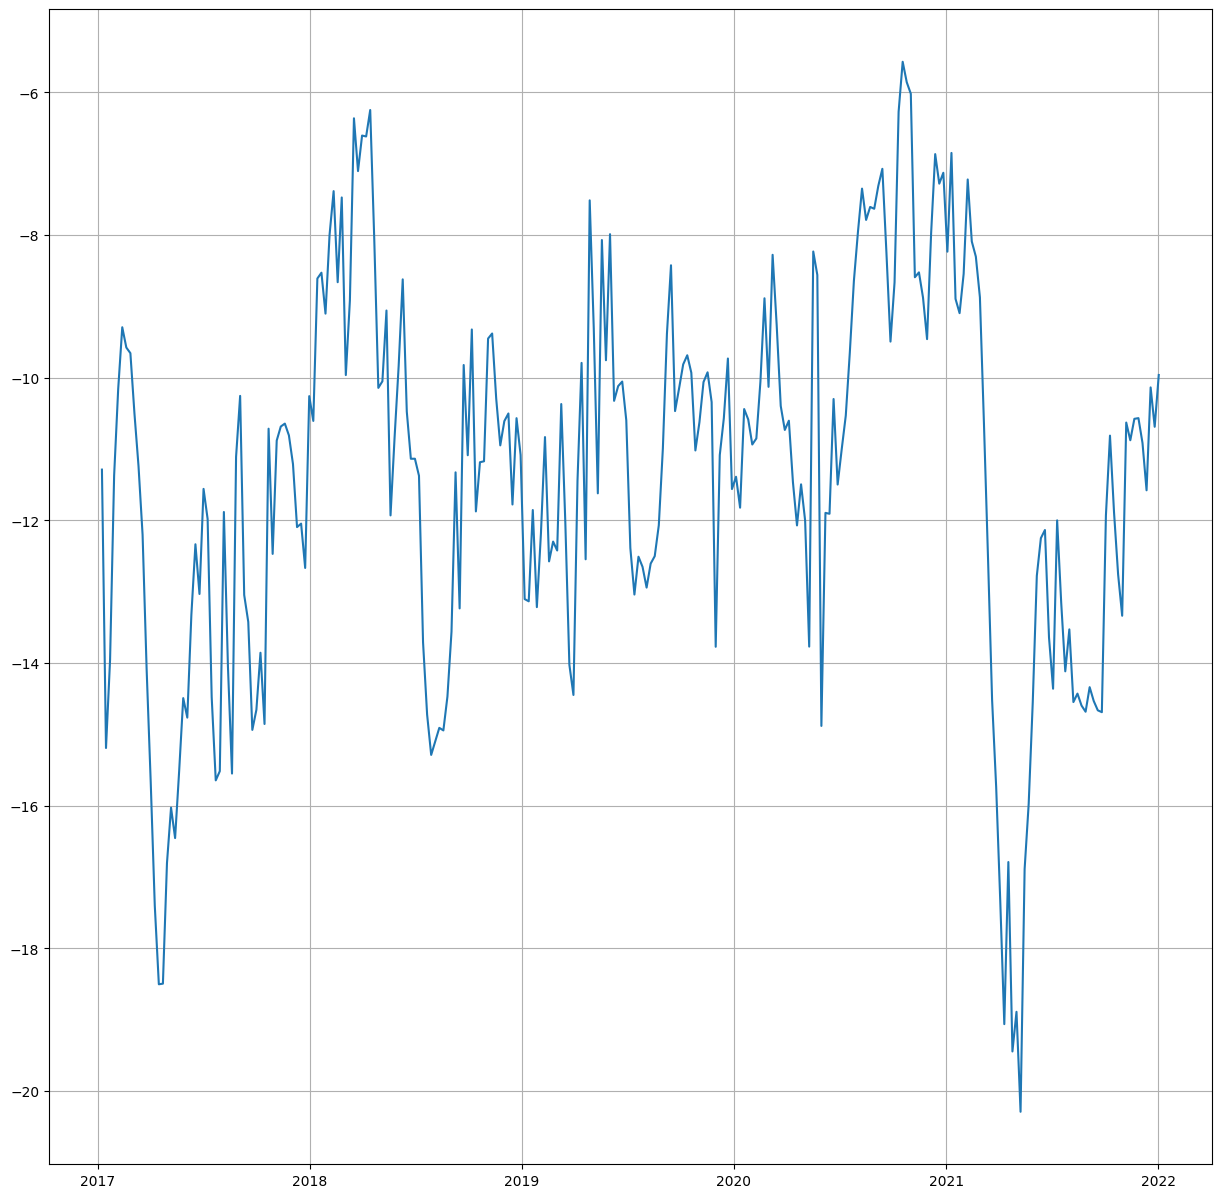

In [26]:
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

ax.plot(tmp)

In [ ]:
# %%time
# ## 7028327.31,8486660.66
# 951512.8,5606858.3
# 951839.1,5606838.9
# 951419.6,5606178.6
# 951804.2,5606182.5
# stack_da.sel(x=4580070, y=1362930, method='nearest')[:, 0].resample(time='W').mean().plot.line()
# # stack_da[:, 0, 8, 8].resample(time='W').mean().plot.line()

In [ ]:
# %%time
# ## 7040228.51,8558737.93
# # 951533,5608017
# stack_da.sel(x=7040228.51, y=8558737.93, method='nearest')[:, 0].resample(time='W').mean().plot.line()
# # stack_da[:, 0, 8, 8].resample(time='W').mean().plot.line()

In [ ]:
# %%time
# stack_da[:, 0, 8, 8].resample(time='W').mean().plot.line()

In [ ]:
# %%time
# # v = stack_da[0:100,:,8,8].values
# v = stack_da[:,:,8,8].values

In [ ]:
# flatted_v = [i[0] for i in v]
# df = pd.DataFrame(zip(date_indices, flatted_v), columns=['timestamp', 'band'])

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(df)

In [ ]:
# # plot_df = df[~np.isnan(df.value)]

# fig, ax = plt.subplots()
# fig.set_figheight(7)
# fig.set_figwidth(10)
# ax.scatter(df.timestamp, df.band)

In [ ]:
# stack_da[0,0,:5000,:5000].plot.imshow()

## Misc. Note

### Sigma Nought
Scattering coefficient, or the conventional measure of the strength of radar signals reflected by a distributed scatterer, usually expressed in dB. It is a normalised dimensionless number, comparing the strength observed to that expected from an area of one square meter. Sigma nought is defined with respect to the nominally horizontal plane, and in general has a significant variation with incidence angle, wavelength, and polarisation, as well as with properties of the scattering surface itself.